In [51]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)


from scipy.optimize import curve_fit

import misc_util

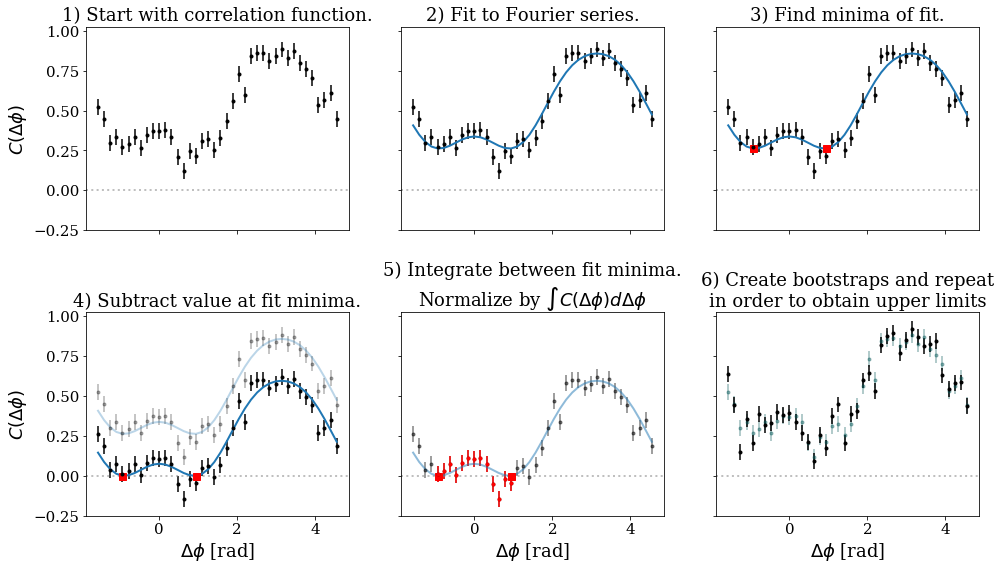

In [57]:

fig,axs = plt.subplots(2,3, figsize=(16,9),sharey='all',sharex='all')
fig.subplots_adjust(hspace=0.4)
#axs[0][0].set_ylim(0)

n=3

x = np.arange(-np.pi/2,np.pi*3/2, np.pi/20)
y = 0.5-0.3*np.cos(x)+.1*np.cos(2*x)+.05*np.cos(3*x)
dy = np.full(len(x),.05)
y = y+np.random.randn(len(dy))*dy*(dy<999)


if n==3:
    def f (xx,b0,b1,b2,b3):
        args=[b0,b1,b2,b3]
        tot = 0
        for i in range(len(args)):
            tot+=args[i]*np.cos(i*xx)
        return tot

if n==4:
    def f (xx,b0,b1,b2,b3,b4):
        args=[b0,b1,b2,b3,b4]
        tot = 0
        for i in range(len(args)):
            tot+=args[i]*np.cos(i*xx)
        return tot
if n==5:
    def f (xx,b0,b1,b2,b3,b4,b5):
        args=[b0,b1,b2,b3,b4,b5]
        tot = 0
        for i in range(len(args)):
            tot+=args[i]*np.cos(i*xx)
        return tot
b,bcov = curve_fit(f, x, y,sigma=dy)

fitrange=[0, np.pi]
#don't waste your time if f''[0] is positive
fpp0= sum([-i*i*b[i] for i in range(len(b))])
#print(fpp0) 
s = 0
for i in range(0,n+1):
    s = b[i]*np.cos(i*x)+s
    
smin = max(s)

xmin=fitrange[0]
for xi,si in zip(x,s):
    if(xi<fitrange[0]):
        continue
    if(si<smin):
        xmin = xi
        smin = si
integral = 0
dx = x[1]-x[0]
for xi,yi in zip(x,y):
    if(xi<xmin):
        integral+=(yi-smin)*dx
    else:
        break
yeild = integral
yeild /= sum(y)*dx



markersize=3
fitcolor='tab:blue'
fitlinewidth=3

plt.sca(axs[0][0])
plt.title("1) Start with correlation function.")
plt.axhline(0,alpha=0.5,color='0.5',linestyle=':',linewidth=2)
plt.errorbar(x,y,dy,linestyle='',color='k',marker='o',markersize=markersize)

plt.sca(axs[0][1])
plt.title("2) Fit to Fourier series.")
plt.axhline(0,alpha=0.5,color='0.5',linestyle=':',linewidth=2)
plt.errorbar(x,y,dy,linestyle='',color='k',marker='o',markersize=markersize)
plt.plot(x,s,color='tab:blue',linestyle='-',linewidth=2)

plt.sca(axs[0][2])
plt.title("3) Find minima of fit.")
plt.axhline(0,alpha=0.5,color='0.5',linestyle=':',linewidth=2)
plt.errorbar(x,y,dy,linestyle='',color='k',marker='o',markersize=markersize)
plt.plot(x,s,color='tab:blue',linestyle='-',linewidth=2)
plt.plot([xmin,-xmin], [smin,smin],marker='s',color='r',linestyle='', markersize=7)


plt.sca(axs[1][0])
plt.title("4) Subtract value at fit minima.")
plt.axhline(0,alpha=0.5,color='0.5',linestyle=':',linewidth=2)

plt.errorbar(x,y,dy,linestyle='',color='k',marker='o',alpha=0.3,markersize=markersize)
plt.plot(x,s,color='tab:blue',linestyle='-',alpha=0.3,linewidth=2)

plt.errorbar(x,y-smin,dy,linestyle='',color='k',marker='o',markersize=markersize)
plt.plot(x,s-smin,color='tab:blue',linestyle='-',linewidth=2)
plt.plot([xmin,-xmin], [0,0],marker='s',color='r',linestyle='', markersize=7)


plt.sca(axs[1][1])
plt.title("5) Integrate between fit minima.\nNormalize by $\int C(\Delta\phi) d\Delta\phi$")
plt.axhline(0,alpha=0.5,color='0.5',linestyle=':',linewidth=2)

plt.errorbar(x,y-smin,dy,linestyle='',color='k',marker='o',markersize=markersize,alpha=0.5)
plt.plot(x,s-smin,color='tab:blue',linestyle='-', alpha=0.5,linewidth=2)

plt.errorbar(x[abs(x)<=xmin],(y-smin)[abs(x)<=xmin],dy[abs(x)<=xmin],linestyle='',
             color='r',marker='o',markersize=markersize)
plt.plot([xmin,-xmin], [0,0],marker='s',color='r',linestyle='', markersize=7)

plt.sca(axs[1][2])
plt.title("6) Create bootstraps and repeat\nin order to obtain upper limits")
plt.axhline(0,alpha=0.5,color='0.5',linestyle=':',linewidth=2)

plt.errorbar(x,y,dy,linestyle='',color='#005555',marker='o',markersize=markersize,alpha=0.4)
plt.errorbar(x,y+np.random.randn(len(dy))*dy*(dy<999),dy,linestyle='',color='k',marker='o',
             markersize=markersize,alpha=1)

for a in axs[1] :
    a.set_xlabel("$\Delta\phi$ [rad]") 
for b in axs:       
    b[0].set_ylabel("$C(\Delta\phi)$")

plt.savefig("../images/ridge_yield_procedure.pdf",bbox_inches='tight')